<a href="https://colab.research.google.com/github/greeshmadh/VISION-Video-Inpainting-for-Seamless-Instant-Object-Removal-and-Background-Reconstruction/blob/main/Copy_of_VISION_Text_guided_Video_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Object Masking and Inpainting

This notebook provides a solution for masking out specific objects in a video based on a text prompt and then inpainting the masked regions. It leverages Detectron2 for object detection and segmentation, CLIP for image-text similarity, and a random walks algorithm for inpainting.

## Setup

1.  **Mount Google Drive:** The code assumes your video file is stored in Google Drive. Ensure you have mounted your Google Drive to `/content/drive`. The first code cell in the notebook handles this.
2.  **Install Dependencies:** The second code cell installs all the necessary libraries, including `torch`, `torchvision`, `opencv-python`, `CLIP`, `pyyaml`, `detectron2`, and `spacy`.
3.  **Download Spacy Model:** The second code cell also downloads the `en_core_web_sm` spacy model.

## How to Use

1.  **Upload your video:** Place your video file in your Google Drive and update the `video_path` variable in the consolidated code cell to point to your video file.
2.  **Run the consolidated code cell:** Execute the code cell that contains the entire video processing pipeline.
3.  **Enter text prompt:** When prompted, enter a text prompt describing the object you want to mask out (e.g., 'red car', 'person on the left'). The code will parse this prompt to identify the object type, color, and position (if specified).

The code will then:
*   Extract frames from your video.
*   Segment the specified object in each frame and create masks.
*   Inpaint the masked regions of the first frame using a random walks (graph) algorithm.
*   Fill the masked pixels in the result frames using the inpainted first frame. This replaces the areas in each frame that were masked out (turned black) during the segmentation step with the content from the inpainted first frame, effectively filling in the removed object.
*   Combine the processed frames into a new video with the specified object masked out and the background inpainted.

## Output

The processed video with the masked object and inpainted background will be saved in the same directory as your input video file, with a filename like `[your_video_filename]_output.mp4`.

Intermediate directories will also be created in the same location to store extracted frames, masks, and intermediate results.

## Customization

*   **`video_path`**: Change this variable to point to your video file.
*   **`fps`**: Adjust the `fps` parameter in the `extract_frames` function to change the frame rate of the extracted frames.
*   **`cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST`**: Modify this threshold in the consolidated code cell to adjust the confidence level for object detection.
*   **`similarity_threshold`**: Change this threshold in the `segment_frames` function to adjust the similarity score required for an object to be considered a match with the text prompt.
*   **`low_threshold` and `high_threshold`**: Adjust these thresholds in the `create_mask_for_inpainting` function to control which pixels are considered damaged and require inpainting.
*   **`frame_rate`**: Adjust the `frame_rate` parameter in the `frames_to_video` function to change the frame rate of the output video.

BASICS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install git+https://github.com/openai/CLIP.git
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
!pip install spacy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

LOADING MODULES

In [ ]:
import torch
import clip
from PIL import Image
import cv2
import numpy as np
import spacy
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [ ]:
# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

nlp = spacy.load("en_core_web_sm")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]
model_final_f10217.pkl: 178MB [00:00, 208MB/s]                           


OBJECT DETECTION AND MASKING

In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os
import cv2
import numpy as np
from PIL import Image
from datetime import datetime
import spacy

import clip
from google.colab.patches import cv2_imshow

# Initialize Detectron2 model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Initialize CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Load Spacy model
nlp = spacy.load("en_core_web_sm")

# Function to extract frames from the video
def extract_frames(video_path, output_dir, fps=25):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_capture = cv2.VideoCapture(video_path)
    original_fps = video_capture.get(cv2.CAP_PROP_FPS)
    print(f"Original FPS: {original_fps}")

    frame_interval = int(original_fps / fps) if original_fps >= fps else 1
    frame_count = 0
    saved_frame_count = 0

    while video_capture.isOpened():
        ret, frame = video_capture.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_dir, f'frame_{saved_frame_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1
        frame_count += 1

    video_capture.release()
    print(f"Extracted {saved_frame_count} frames and saved to {output_dir}")

def calculate_similarity(image, text, model, preprocess):
    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize([text]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    return torch.cosine_similarity(image_features, text_features).item()

def parse_prompt(prompt):
    doc = nlp(prompt)
    color = None
    position = None
    object_type = None

    color_keywords = {"red", "blue", "green", "black", "white", "yellow", "gray"}
    position_keywords = {"left", "right", "top", "bottom", "center"}

    for token in doc:
        if token.text.lower() in color_keywords:
            color = token.text.lower()
        elif token.text.lower() in position_keywords:
            position = token.text.lower()
        elif token.pos_ == "NOUN":
            object_type = token.text.lower()

    return color, position, object_type

def is_position_match(box, position, image_shape):
    x1, y1, x2, y2 = box
    height, width, _ = image_shape

    if position == "left" and x2 > width / 2:
        return False
    if position == "right" and x1 < width / 2:
        return False
    if position == "top" and y2 > height / 2:
        return False
    if position == "bottom" and y1 < height / 2:
        return False
    if position == "center" and not (width / 4 < x1 < 3 * width / 4 and height / 4 < y1 < 3 * height / 4):
        return False

    return True

def filter_by_color(image, mask, color):
    mask_bool = mask.astype(bool)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    color_ranges = {
        "red": [((0, 50, 50), (10, 255, 255)), ((160, 50, 50), (180, 255, 255))],
        "blue": [((100, 50, 50), (140, 255, 255))],
        "green": [((40, 50, 50), (80, 255, 255))],
        "black": [((0, 0, 0), (180, 255, 50))],
        "white": [((0, 0, 200), (180, 30, 255))],
        "yellow": [((20, 50, 50), (40, 255, 255))],
        "gray": [((0, 0, 50), (180, 30, 200))],
    }

    for lower, upper in color_ranges.get(color, [((0, 0, 0), (180, 255, 255))]):
        mask_color = cv2.inRange(image_hsv, np.array(lower), np.array(upper))

        # Debugging output
        debug_combined_mask = np.logical_and(mask_bool, mask_color > 0)
        #print(f"Debug Combined Mask: {debug_combined_mask}")

        combined_mask = np.logical_and(mask_bool, mask_color > 0)
        if np.any(combined_mask):
            return True
    return False

def segment_frames(input_dir, output_mask_dir, output_result_dir, object_type, color=None, position=None):
    os.makedirs(output_mask_dir, exist_ok=True)
    os.makedirs(output_result_dir, exist_ok=True)

    for frame_filename in os.listdir(input_dir):
        frame_path = os.path.join(input_dir, frame_filename)
        frame = cv2.imread(frame_path)

        # Detect objects in the image using Detectron2
        outputs = predictor(frame)
        instances = outputs["instances"]

        scores = instances.scores.cpu().numpy()
        masks = instances.pred_masks.cpu().numpy()
        boxes = instances.pred_boxes.tensor.cpu().numpy()

        similarity_threshold = 0.25  # Adjust this threshold as needed
        matching_boxes = []
        matching_masks = []

        # Inside the main loop where you calculate similarity
        for i in range(len(boxes)):
            box = boxes[i]
            x1, y1, x2, y2 = map(int, box)

            # Calculate object dimensions
            box_width = x2 - x1
            box_height = y2 - y1
            box_area = box_width * box_height

            # Check if the object is very small (you can adjust this threshold as needed)
            if box_area < 2000:  # Adjust this threshold based on your image scale
                continue

            cropped_image = Image.fromarray(frame[y1:y2, x1:x2])

            # Calculate similarity using CLIP and print debug information
            similarity = calculate_similarity(cropped_image, object_type, clip_model, preprocess)
            print(f"Object: {object_type}, Similarity: {similarity}, Box: {box}")

            if similarity > similarity_threshold:
                if color and not filter_by_color(frame, masks[i], color):
                    print(f"Skipping object in box {box} due to color mismatch.")
                    continue  # Skip if the color does not match
                matching_boxes.append(box)
                matching_masks.append(masks[i])

        # Filter matching objects based on positional keywords
        final_boxes = []
        final_masks = []

        for i, box in enumerate(matching_boxes):
            if position and not is_position_match(box, position, frame.shape):
                print(f"Skipping object in box {box} due to position mismatch.")
                continue  # Skip if the position does not match
            final_boxes.append(box)
            final_masks.append(matching_masks[i])

        # Initialize an empty mask
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        for final_mask in final_masks:
            mask = cv2.bitwise_or(mask, final_mask.astype(np.uint8))

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)

        mask = (mask * 255).astype(np.uint8)
        mask_image_path = os.path.join(output_mask_dir, frame_filename)
        cv2.imwrite(mask_image_path, mask)

        # Subtract the mask from the original image
        mask_3_channel = cv2.merge([mask, mask, mask])
        color_result = cv2.subtract(frame, mask_3_channel)

        result_image_path = os.path.join(output_result_dir, frame_filename)
        cv2.imwrite(result_image_path, color_result)

# Function to combine frames into a video
def frames_to_video(input_folder, output_video_path, frame_rate=25):
    frames = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    frames.sort()

    if not frames:
        print(f"No frames found in {input_folder}")
        return

    first_frame_path = os.path.join(input_folder, frames[0])
    first_frame = cv2.imread(first_frame_path)
    height, width, layers = first_frame.shape
    frame_size = (width, height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)

    for frame_file in frames:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"Video saved at {output_video_path}")

# Main function to process the video
#def process_video(video_path, frames_output_dir, mask_output_dir, result_output_dir, output_video_path, object_type, color=None, position=None):
def process_video(video_path):
    video_filename = os.path.basename(video_path).split('.')[0]
    base_output_dir = os.path.dirname(video_path)

    # Define directories based on the video filename
    frames_output_dir = os.path.join(base_output_dir, f'frames_{video_filename}')
    mask_output_dir = os.path.join(base_output_dir, f'masks_{video_filename}')
    result_output_dir = os.path.join(base_output_dir, f'results_{video_filename}')
    output_video_path = os.path.join(base_output_dir, f'{video_filename}_masked_out.mp4')

    # Step 1: Extract frames from the video
    extract_frames(video_path, frames_output_dir, fps=25)

    # Step 2: Parse the user input and get object type
    user_text = input("Enter your text prompt: ")
    color, position, object_type = parse_prompt(user_text)
    print(f"Parsed prompt - Color: {color}, Position: {position}, Object: {object_type}")

    # Step 3: Segment the extracted frames and create masks
    segment_frames(frames_output_dir, mask_output_dir, result_output_dir, object_type, color, position)

    # Step 4: Combine processed frames into a video
    frames_to_video(result_output_dir, output_video_path, frame_rate=25)

# Example usage
video_path = '/content/drive/MyDrive/vehicle7.mp4'  # Provide the path to your video file
process_video(video_path)


[08/15 13:38:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Original FPS: 25.0
Extracted 80 frames and saved to /content/drive/MyDrive/frames_vehicle7
Enter your text prompt: car
Parsed prompt - Color: None, Position: None, Object: car


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Object: car, Similarity: 0.229736328125, Box: [  8.61904 331.72626 206.07175 447.98605]
Object: car, Similarity: 0.280029296875, Box: [113.97376 393.4238  431.93765 502.58203]
Object: car, Similarity: 0.233642578125, Box: [  7.213493 331.36288  213.48473  447.96158 ]
Object: car, Similarity: 0.2822265625, Box: [114.12176 392.70517 442.077   505.09787]
Object: car, Similarity: 0.2327880859375, Box: [  8.268641 331.57202  208.2099   448.0509  ]
Object: car, Similarity: 0.286865234375, Box: [130.44978 393.39243 451.2908  503.63434]
Object: car, Similarity: 0.2291259765625, Box: [  8.017365 330.79446  206.12643  447.26495 ]
Object: car, Similarity: 0.278564453125, Box: [150.819   390.81683 468.591   502.118  ]
Object: car, Similarity: 0.289794921875, Box: [157.17828 390.1214  482.61008 502.9153 ]
Object: car, Similarity: 0.2298583984375, Box: [  7.365131 331.39545  205.18912  448.22723 ]
Object: car, Similarity: 0.291259765625, Box: [166.66133 391.53244 497.39905 503.58774]
Object: car, Si

INPAINTING MANUAL STEP

In [ ]:
import cv2
import numpy as np
import os

# Define the video path
video_path = '/content/drive/MyDrive/vehicle7.mp4'
video_filename = os.path.basename(video_path).split('.')[0]

# Define directories based on the video filename
base_dir = os.path.dirname(video_path)
result_folder = os.path.join(base_dir, f'results_{video_filename}')
final_folder = os.path.join(base_dir, f'final_{video_filename}')
filled_result_folder = os.path.join(base_dir, f'filled_{video_filename}')  # New folder to save filled result frames

# Automatically get the last image from the final folder
final_image_files = sorted([f for f in os.listdir(final_folder) if f.endswith('.jpg')])
if not final_image_files:
    raise FileNotFoundError(f"No JPEG images found in {final_folder}")
final_image_path = os.path.join(final_folder, final_image_files[-1])

# Load final image
last_inpaint = cv2.imread(final_image_path)
if last_inpaint is None:
    raise FileNotFoundError(f"Failed to load {final_image_path}")

# Load the first result image
first_result_path = os.path.join(result_folder, 'frame_0000.jpg')
first_result = cv2.imread(first_result_path)
if first_result is None:
    raise FileNotFoundError(f"Failed to load {first_result_path}")

# Perform bitwise OR operation to create final image
final_image = cv2.bitwise_or(first_result, last_inpaint)

# Get sorted list of image files in result_folder
result_files = sorted([f for f in os.listdir(result_folder) if f.endswith('.jpg')])

# Create filled_result_folder if it doesn't exist
os.makedirs(filled_result_folder, exist_ok=True)

# Iterate through each frame in result_folder
for result_file in result_files:
    result_path = os.path.join(result_folder, result_file)

    # Read result frame
    result_frame = cv2.imread(result_path)
    if result_frame is None:
        raise FileNotFoundError(f"Failed to load {result_path}")

    # Create mask: True where pixel in result_frame is [0, 0, 0] (black)
    mask = (result_frame == [0, 0, 0]).all(axis=2)

    # Replace black pixels in result_frame with corresponding pixels from final_image
    result_frame[mask] = final_image[mask]

    # Save modified result frame to filled_result_folder
    filled_result_path = os.path.join(filled_result_folder, result_file)
    cv2.imwrite(filled_result_path, result_frame)

    print(f"Filled masked pixels and saved: {filled_result_path}")

print("Masked pixel filling complete. Results saved to:", filled_result_folder)


Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0000.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0001.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0002.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0003.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0004.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0005.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0006.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0007.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0008.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0009.jpg
Filled masked pixels and saved: /content/drive/MyDrive/filled_vehicle7/frame_0010.jpg
Filled masked pixels and saved: /content/drive/MyDrive

Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0001.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0002.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0003.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0004.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0005.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0006.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0007.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0008.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0009.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0010.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0011.jpg
Inpainted and saved: /content/drive/MyDrive/final_vehicle7/inpaint_frame_0012.jpg
Inpainted and sa

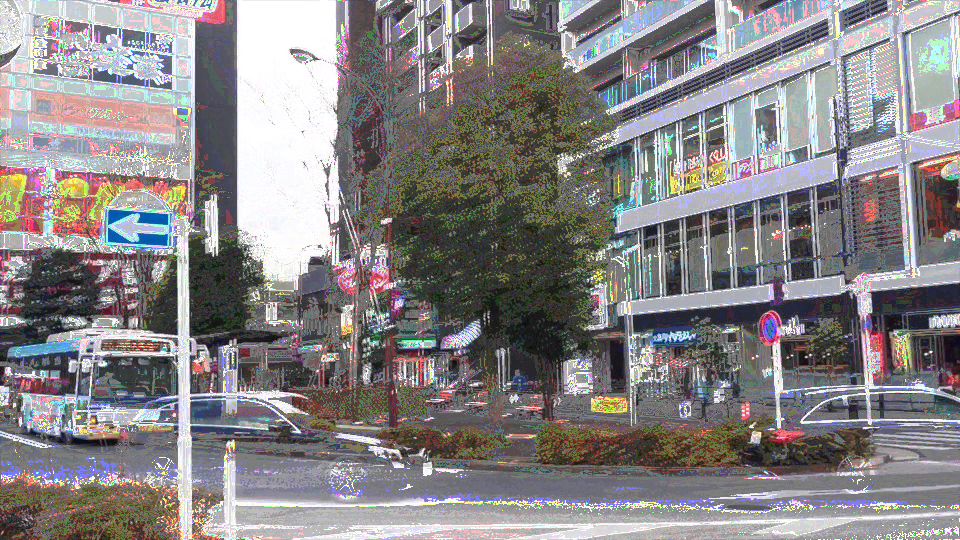

Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0000.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0001.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0002.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0003.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0004.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0005.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0006.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0007.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0008.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0009.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0010.jpg
Filled masked pixels in: /content/drive/MyDrive/results_vehicle7/frame_0011.jpg
Filled masked pixels in: /content/drive/

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# Define directories based on the video filename
video_path = '/content/drive/MyDrive/vehicle7.mp4'
video_filename = os.path.basename(video_path).split('.')[0]
base_dir = os.path.dirname(video_path)

frames_dir = os.path.join(base_dir, f'frames_{video_filename}')
mask_dir = os.path.join(base_dir, f'masks_{video_filename}')
result_dir = os.path.join(base_dir, f'results_{video_filename}')
final_dir = os.path.join(base_dir, f'final_{video_filename}')

# Create final directory if it doesn't exist
os.makedirs(final_dir, exist_ok=True)

# Get sorted list of image files
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg')])
result_files = sorted([f for f in os.listdir(result_dir) if f.endswith('.jpg')])
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

# Check that the directories are not empty and contain the same number of files
if not mask_files or not result_files or len(mask_files) != len(result_files):
    raise FileNotFoundError("Directories are empty or do not contain the same number of files.")

# Process each pair of consecutive frames
for i in range(len(mask_files)):
    # Read images
    if i == 0:
        # First frame in mask folder
        first_mask_path = os.path.join(mask_dir, mask_files[i])
        first_mask = cv2.imread(first_mask_path)
        if first_mask is None:
            raise FileNotFoundError(f"Failed to load {first_mask_path}")
    else:
        # Subsequent frames in mask folder
        mask_path = os.path.join(mask_dir, mask_files[i])
        mask_frame = cv2.imread(mask_path)
        if mask_frame is None:
            raise FileNotFoundError(f"Failed to load {mask_path}")

        # Compute absolute difference with first mask frame
        diff_mask = cv2.absdiff(first_mask, mask_frame)

        # Inpaint using corresponding pixels from result folder
        result_path = os.path.join(result_dir, result_files[i])
        result_frame = cv2.imread(result_path)
        if result_frame is None:
            raise FileNotFoundError(f"Failed to load {result_path}")

        # Replace pixels in diff_mask with corresponding pixels from result_frame
        for channel in range(3):  # iterate over B, G, R channels
            diff_mask[:, :, channel] = np.where(diff_mask[:, :, channel] == 255,
                                                result_frame[:, :, channel],
                                                diff_mask[:, :, channel])

        # Save inpainted result to final folder
        final_path = os.path.join(final_dir, f'inpaint_{mask_files[i]}')
        cv2.imwrite(final_path, diff_mask)

        print(f"Inpainted and saved: {final_path}")

print("Inpainting complete. Results saved to:", final_dir)

# Automatically get the first and last file from the frames folder
first_frame_path = os.path.join(frames_dir, frame_files[0])
last_frame_path = os.path.join(frames_dir, frame_files[-1])

first_frame = cv2.imread(first_frame_path)
last_frame = cv2.imread(last_frame_path)

if first_frame is None:
    raise FileNotFoundError(f"Failed to load {first_frame_path}")
if last_frame is None:
    raise FileNotFoundError(f"Failed to load {last_frame_path}")

final = cv2.bitwise_or(first_frame, last_frame)
cv2_imshow(final)
cv2.waitKey(0)
cv2.destroyAllWindows()

result_folder = os.path.join(base_dir, f'results_{video_filename}')
final_image_path = os.path.join(base_dir, f'results_{video_filename}', 'frame_0000.jpg')  # Ensure this is a valid image file

# Load final image
final_image = cv2.imread(final_image_path)
if final_image is None:
    raise FileNotFoundError(f"Failed to load {final_image_path}")

# Get sorted list of image files in result_folder
result_files = sorted([f for f in os.listdir(result_folder) if f.endswith('.jpg')])

# Iterate through each frame in result_folder
for result_file in result_files:
    result_path = os.path.join(result_folder, result_file)

    # Read result frame
    result_frame = cv2.imread(result_path)
    if result_frame is None:
        raise FileNotFoundError(f"Failed to load {result_path}")

    # Create mask: True where pixel in result_frame is [0, 0, 0] (black)
    mask = (result_frame == [0, 0, 0]).all(axis=2)

    # Replace black pixels in result_frame with corresponding pixels from final_image
    result_frame[mask] = final_image[mask]

    # Save modified result frame back to result_folder
    cv2.imwrite(result_path, result_frame)

    print(f"Filled masked pixels in: {result_path}")

print("Masked pixel filling complete.")


INPAINTING-GRAPH STEP

In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve
import cv2
import os

def create_mask(image, low_threshold=15, high_threshold=240):
    """
    Create a binary mask for inpainting based on low and high thresholds.
    Pixels below the low threshold or above the high threshold are considered damaged.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale using RGB
    mask = np.zeros(gray_image.shape, dtype=np.uint8)
    mask[(gray_image < low_threshold) | (gray_image > high_threshold)] = 255
    return mask

def inpaint_random_walks(image, mask):
    height, width, channels = image.shape
    inpainted_image = np.zeros_like(image)
    n = height * width
    indices = np.arange(n).reshape(height, width)

    # Create the Laplacian matrix more efficiently
    L = lil_matrix((n, n))

    for i in range(height):
        for j in range(width):
            idx = indices[i, j]
            if mask[i, j] == 0:  # Known pixel
                L[idx, idx] = 1
            else:  # Unknown pixel
                neighbors = []
                if i > 0: neighbors.append(indices[i - 1, j])
                if i < height - 1: neighbors.append(indices[i + 1, j])
                if j > 0: neighbors.append(indices[i, j - 1])
                if j < width - 1: neighbors.append(indices[i, j + 1])
                w_sum = len(neighbors)
                L[idx, idx] = w_sum
                for neighbor in neighbors:
                    L[idx, neighbor] = -1

    L = L.tocsc()  # Convert to CSC format once

    for c in range(channels):
        img_channel = image[:, :, c]
        known_pixels = img_channel[mask == 0].reshape(-1)
        b = np.zeros(n)
        b[indices[mask == 0]] = known_pixels

        # Solve the linear system
        x = spsolve(L, b)
        inpainted_channel = x.reshape(height, width).astype(np.uint8)
        inpainted_channel[mask == 0] = img_channel[mask == 0]

        inpainted_image[:, :, c] = inpainted_channel

    return inpainted_image

def process_frames(input_folder, output_video):
    # Get a list of all image files in the input folder
    image_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.jpg')])

    if not image_files:
        raise FileNotFoundError(f"No JPEG images found in {input_folder}")

    # Read the first image to get dimensions
    first_image = cv2.imread(image_files[0])
    height, width, channels = first_image.shape

    # Create VideoWriter object to write the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust codec as needed
    out = cv2.VideoWriter(output_video, fourcc, 30.0, (width, height))

    # Process each frame
    for idx, image_path in enumerate(image_files):
        image = cv2.imread(image_path)

        # Create mask based on low and high thresholding
        mask = create_mask(image, low_threshold=15, high_threshold=240)

        # Perform inpainting
        inpainted_image = inpaint_random_walks(image, mask)

        # Write frame to output video
        out.write(inpainted_image)
        print(f"Processed frame {idx+1}/{len(image_files)}")

    # Release VideoWriter object and close all windows
    out.release()
    cv2.destroyAllWindows()
    print(f"Video saved as {output_video}")

# Define directories based on the video filename
video_path = '/content/drive/MyDrive/vehicle7.mp4'
video_filename = os.path.basename(video_path).split('.')[0]
base_dir = os.path.dirname(video_path)

# Input folder containing frames and output video path
input_folder = os.path.join(base_dir, f'filled_{video_filename}')
output_video = os.path.join(base_dir, f'{video_filename}_output.mp4')

# Process frames and create the video
process_frames(input_folder, output_video)


Processed frame 1/80
Processed frame 2/80
Processed frame 3/80
Processed frame 4/80
Processed frame 5/80
Processed frame 6/80
Processed frame 7/80
Processed frame 8/80
Processed frame 9/80
Processed frame 10/80
Processed frame 11/80
Processed frame 12/80
Processed frame 13/80
Processed frame 14/80
Processed frame 15/80
Processed frame 16/80
Processed frame 17/80
Processed frame 18/80
Processed frame 19/80
Processed frame 20/80
Processed frame 21/80
Processed frame 22/80
Processed frame 23/80
Processed frame 24/80
Processed frame 25/80
Processed frame 26/80
Processed frame 27/80
Processed frame 28/80
Processed frame 29/80
Processed frame 30/80
Processed frame 31/80
Processed frame 32/80
Processed frame 33/80
Processed frame 34/80
Processed frame 35/80
Processed frame 36/80
Processed frame 37/80
Processed frame 38/80
Processed frame 39/80
Processed frame 40/80
Processed frame 41/80
Processed frame 42/80
Processed frame 43/80
Processed frame 44/80
Processed frame 45/80
Processed frame 46/

# CONSOLIDATED CODE

In [ ]:
# Define the path to your video file here
video_path = '/content/drive/MyDrive/vehicle7.mp4'  # Replace with the actual path to your video

# Initialize Detectron2 model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Initialize CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Load Spacy model
nlp = spacy.load("en_core_web_sm")


def extract_frames(video_path, output_dir, fps=25):
    """Extracts frames from a video file."""
    print("## 2. Frame Extraction")
    print(f"Extracting frames from the video: `{video_path}` and saving to `{output_dir}`.")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_capture = cv2.VideoCapture(video_path)
    original_fps = video_capture.get(cv2.CAP_PROP_FPS)
    print(f"- Original FPS: **{original_fps}**")

    frame_interval = int(original_fps / fps) if original_fps >= fps else 1
    frame_count = 0
    saved_frame_count = 0

    while video_capture.isOpened():
        ret, frame = video_capture.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_dir, f'frame_{saved_frame_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1
        frame_count += 1

    video_capture.release()
    print(f"- Extracted **{saved_frame_count}** frames and saved to `{output_dir}`")


def calculate_similarity(image, text, model, preprocess):
    """Calculates the cosine similarity between an image and text using CLIP."""
    image = preprocess(image).unsqueeze(0).to(device)
    text = clip.tokenize([text]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    return torch.cosine_similarity(image_features, text_features).item()


def parse_prompt(prompt):
    """Parses a text prompt to extract object type, color, and position."""
    doc = nlp(prompt)
    color = None
    position = None
    object_type = None

    color_keywords = {"red", "blue", "green", "black", "white", "yellow", "gray"}
    position_keywords = {"left", "right", "top", "bottom", "center"}

    for token in doc:
        if token.text.lower() in color_keywords:
            color = token.text.lower()
        elif token.text.lower() in position_keywords:
            position = token.text.lower()
        elif token.pos_ == "NOUN":
            object_type = token.text.lower()

    return color, position, object_type


def is_position_match(box, position, image_shape):
    """Checks if a bounding box matches the specified position."""
    x1, y1, x2, y2 = box
    height, width, _ = image_shape

    if position == "left" and x2 > width / 2:
        return False
    if position == "right" and x1 < width / 2:
        return False
    if position == "top" and y2 > height / 2:
        return False
    if position == "bottom" and y1 > height / 2: # Fixed condition
        return False
    if position == "center" and not (width / 4 < x1 < 3 * width / 4 and height / 4 < y1 < 3 * height / 4):
        return False

    return True


def filter_by_color(image, mask, color):
    """Filters a mask based on the color of the masked region."""
    mask_bool = mask.astype(bool)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    color_ranges = {
        "red": [((0, 50, 50), (10, 255, 255)), ((160, 50, 50), (180, 255, 255))],
        "blue": [((100, 50, 50), (140, 255, 255))],
        "green": [((40, 50, 50), (80, 255, 255))],
        "black": [((0, 0, 0), (180, 255, 50))],
        "white": [((0, 0, 200), (180, 30, 255))],
        "yellow": [((20, 50, 50), (40, 255, 255))],
        "gray": [((0, 0, 50), (180, 30, 200))],
    }

    for lower, upper in color_ranges.get(color, [((0, 0, 0), (180, 255, 255))]):
        mask_color = cv2.inRange(image_hsv, np.array(lower), np.array(upper))
        combined_mask = np.logical_and(mask_bool, mask_color > 0)
        if np.any(combined_mask):
            return True
    return False


def segment_frames(input_dir, output_mask_dir, output_result_dir, object_type, color=None, position=None):
    """Segments objects in frames and creates masks."""
    print("## 3. Object Segmentation and Masking")
    print(f"Segmenting frames to identify '**{object_type}**' (Color: **{color}**, Position: **{position}**).")
    print(f"Masks will be saved to `{output_mask_dir}` and masked results to `{output_result_dir}`.")
    os.makedirs(output_mask_dir, exist_ok=True)
    os.makedirs(output_result_dir, exist_ok=True)

    for frame_filename in os.listdir(input_dir):
        frame_path = os.path.join(input_dir, frame_filename)
        frame = cv2.imread(frame_path)

        outputs = predictor(frame)
        instances = outputs["instances"]

        scores = instances.scores.cpu().numpy()
        masks = instances.pred_masks.cpu().numpy()
        boxes = instances.pred_boxes.tensor.cpu().numpy()

        similarity_threshold = 0.25
        matching_boxes = []
        matching_masks = []

        for i in range(len(boxes)):
            box = boxes[i]
            x1, y1, x2, y2 = map(int, box)
            box_width = x2 - x1
            box_height = y2 - y1
            box_area = box_width * box_height

            if box_area < 2000:
                continue

            cropped_image = Image.fromarray(frame[y1:y2, x1:x2])
            similarity = calculate_similarity(cropped_image, object_type, clip_model, preprocess)

            if similarity > similarity_threshold:
                if color and not filter_by_color(frame, masks[i], color):
                    print(f"- Skipping object in frame **{frame_filename}**, box **{box}** due to color mismatch.")
                    continue
                matching_boxes.append(box)
                matching_masks.append(masks[i])

        final_boxes = []
        final_masks = []

        for i, box in enumerate(matching_boxes):
            if position and not is_position_match(box, position, frame.shape):
                print(f"- Skipping object in frame **{frame_filename}**, box **{box}** due to position mismatch.")
                continue
            final_boxes.append(box)
            final_masks.append(matching_masks[i])

        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        for final_mask in final_masks:
            mask = cv2.bitwise_or(mask, final_mask.astype(np.uint8))

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=3)

        mask = (mask * 255).astype(np.uint8)
        mask_image_path = os.path.join(output_mask_dir, frame_filename)
        cv2.imwrite(mask_image_path, mask)

        mask_3_channel = cv2.merge([mask, mask, mask])
        color_result = cv2.subtract(frame, mask_3_channel)

        result_image_path = os.path.join(output_result_dir, frame_filename)
        cv2.imwrite(result_image_path, color_result)


def create_mask_for_inpainting(image, low_threshold=15, high_threshold=240):
    """
    Create a binary mask for inpainting based on low and high thresholds.
    Pixels below the low threshold or above the high threshold are considered damaged.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = np.zeros(gray_image.shape, dtype=np.uint8)
    mask[(gray_image < low_threshold) | (gray_image > high_threshold)] = 255
    return mask


def inpaint_random_walks(image, mask):
    """Performs inpainting using the random walks algorithm."""
    height, width, channels = image.shape
    inpainted_image = np.zeros_like(image)
    n = height * width
    indices = np.arange(n).reshape(height, width)

    L = lil_matrix((n, n))

    for i in range(height):
        for j in range(width):
            idx = indices[i, j]
            if mask[i, j] == 0:
                L[idx, idx] = 1
            else:
                neighbors = []
                if i > 0: neighbors.append(indices[i - 1, j])
                if i < height - 1: neighbors.append(indices[i + 1, j])
                if j > 0: neighbors.append(indices[i, j - 1])
                if j < width - 1: neighbors.append(indices[i, j + 1])
                w_sum = len(neighbors)
                L[idx, idx] = w_sum
                for neighbor in neighbors:
                    L[idx, neighbor] = -1

    L = L.tocsc()

    for c in range(channels):
        img_channel = image[:, :, c]
        known_pixels = img_channel[mask == 0].reshape(-1)
        b = np.zeros(n)
        b[indices[mask == 0]] = known_pixels

        x = spsolve(L, b)
        inpainted_channel = x.reshape(height, width).astype(np.uint8)
        inpainted_channel[mask == 0] = img_channel[mask == 0]

        inpainted_image[:, :, c] = inpainted_channel

    return inpainted_image


def fill_masked_pixels(result_folder, final_folder, filled_result_folder):
    """Fills masked pixels in result frames using the inpainted final image."""
    print("## 4. Inpainting Masked Regions")
    print(f"Filling masked pixels in frames from `{result_folder}` using the inpainted first frame and saving to `{filled_result_folder}`.")

    final_image_files = sorted([f for f in os.listdir(final_folder) if f.endswith('.jpg')])
    if not final_image_files:
        print(f"### Error: No JPEG images found in {final_folder}")
        raise FileNotFoundError(f"No JPEG images found in {final_folder}")
    final_image_path = os.path.join(final_folder, final_image_files[-1])

    last_inpaint = cv2.imread(final_image_path)
    if last_inpaint is None:
        print(f"### Error: Failed to load {final_image_path}")
        raise FileNotFoundError(f"Failed to load {final_image_path}")

    first_result_path = os.path.join(result_folder, 'frame_0000.jpg')
    first_result = cv2.imread(first_result_path)
    if first_result is None:
        print(f"### Error: Failed to load {first_result_path} in fill_masked_pixels")
        raise FileNotFoundError(f"Failed to load {first_result_path}")

    final_image = cv2.bitwise_or(first_result, last_inpaint)

    result_files = sorted([f for f in os.listdir(result_folder) if f.endswith('.jpg')])

    os.makedirs(filled_result_folder, exist_ok=True)

    for result_file in result_files:
        result_path = os.path.join(result_folder, result_file)
        result_frame = cv2.imread(result_path)
        if result_frame is None:
            print(f"### Error: Failed to load {result_path} in fill_masked_pixels loop")
            raise FileNotFoundError(f"Failed to load {result_path}")

        mask = (result_frame == [0, 0, 0]).all(axis=2)
        result_frame[mask] = final_image[mask]

        filled_result_path = os.path.join(filled_result_folder, result_file)
        cv2.imwrite(filled_result_path, result_frame)


def frames_to_video(input_folder, output_video_path, frame_rate=25):
    """Combines frames into a video file."""
    print("## 5. Creating Output Video")
    print(f"Combining processed frames from `{input_folder}` into a video: `{output_video_path}`")

    frames = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    frames.sort()

    if not frames:
        print(f"### Error: No frames found in {input_folder}")
        return

    first_frame_path = os.path.join(input_folder, frames[0])
    first_frame = cv2.imread(first_frame_path)
    height, width, layers = first_frame.shape
    frame_size = (width, height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)

    for frame_file in frames:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        out.write(frame)

    out.release()
    print(f"**Video processing complete!** The output video is saved at: `{output_video_path}`")


# Main execution flow
video_filename = os.path.basename(video_path).split('.')[0]
base_output_dir = os.path.dirname(video_path)

frames_output_dir = os.path.join(base_output_dir, f'frames_{video_filename}')
mask_output_dir = os.path.join(base_output_dir, f'masks_{video_filename}')
result_output_dir = os.path.join(base_output_dir, f'results_{video_filename}')
final_inpaint_dir = os.path.join(base_output_dir, f'final_{video_filename}')
filled_result_dir = os.path.join(base_output_dir, f'filled_{video_filename}')
output_video_path = os.path.join(base_output_dir, f'{video_filename}_output.mp4')

# Get text prompt from user
user_text = input("Enter your text prompt for the object to mask out (e.g., 'red car', 'person on the left'): ")


# Ensure user_text is not empty before processing
if not user_text:
    print("### Input Required: Text Prompt")
    print("Please provide a text prompt to specify the object you want to remove.")
else:
    # Step 1: Extract frames
    extract_frames(video_path, frames_output_dir, fps=25)

    # Step 2: Parse prompt
    color, position, object_type = parse_prompt(user_text)
    print("## 2.1 Prompt Parsing")
    print(f"Parsed prompt - Color: **{color}**, Position: **{position}**, Object: **{object_type}**")


    if object_type is None:
        print("### Error: Could not identify object type")
        print("Could not identify the object type from the prompt. Please try a different prompt.")
    else:
        # Step 3: Segment objects and create masks
        segment_frames(frames_output_dir, mask_output_dir, result_output_dir, object_type, color, position)

        # Step 4: Inpaint masks for the first frame
        print("## 4.1 Inpainting First Frame")
        print("Inpainting the masked region in the first frame to provide a background for subsequent frames.")
        mask_files = sorted([f for f in os.listdir(mask_output_dir) if f.endswith('.jpg')])
        if mask_files:
            first_mask_path = os.path.join(mask_output_dir, mask_files[0])
            first_mask = cv2.imread(first_mask_path, cv2.IMREAD_GRAYSCALE)
            if first_mask is not None:
                first_frame_path = os.path.join(frames_output_dir, os.path.basename(mask_files[0]))
                first_frame = cv2.imread(first_frame_path)
                if first_frame is not None:
                    inpainted_first_frame = inpaint_random_walks(first_frame, first_mask) #Inpaint using graph-method
                    os.makedirs(final_inpaint_dir, exist_ok=True)
                    cv2.imwrite(os.path.join(final_inpaint_dir, f'inpaint_{os.path.basename(mask_files[0])}'), inpainted_first_frame)
                    print(f"Inpainted first frame and saved to: `{final_inpaint_dir}`")
                else:
                    print(f"### Error: Could not load first frame")
                    print(f"Could not load first frame: `{first_frame_path}`")
            else:
                 print(f"### Error: Could not load first mask")
                 print(f"Could not load first mask: `{first_mask_path}`")
        else:
            print("### Warning: No masks created")
            print("No masks were created. Cannot perform inpainting.")


        # Step 5: Fill masked pixels in result frames
        fill_masked_pixels(result_output_dir, final_inpaint_dir, filled_result_dir)
        print("Masked pixel filling complete.")

        # Step 6: Combine filled frames into a video
        frames_to_video(filled_result_dir, output_video_path, frame_rate=25)

[08/15 15:02:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Enter your text prompt for the object to mask out (e.g., 'red car', 'person on the left'): black car
## 2. Frame Extraction
Extracting frames from the video: `/content/drive/MyDrive/vehicle7.mp4` and saving to `/content/drive/MyDrive/frames_vehicle7`.
- Original FPS: **25.0**
- Extracted **80** frames and saved to `/content/drive/MyDrive/frames_vehicle7`
## 2.1 Prompt Parsing
Parsed prompt - Color: **black**, Position: **None**, Object: **car**
## 3. Object Segmentation and Masking
Segmenting frames to identify '**car**' (Color: **black**, Position: **None**).
Masks will be saved to `/content/drive/MyDrive/masks_vehicle7` and masked results to `/content/drive/MyDrive/results_vehicle7`.
## 4.1 Inpainting First Frame
Inpainting the masked region in the first frame to provide